In [ ]:
!pip install --upgrade keras tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 98.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
import os
os.environ["KERAS_BACKEND"] = 'tensorflow'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import tensorflow as tf
import pprint
import datetime


from tensorflow import keras
from keras import layers
from keras import ops
from pathlib import Path
from tqdm import tqdm

In [ ]:
# Constant
INPUT_SHAPE = (32, 32, 1)
LABELS = ["ForwardFall", "BackwardFall", "LeftFall", "RightFall", "GetDown", "SitDown", "Walk"]
LABEL2INDEX = dict(zip(LABELS, range(len(LABELS))))
INDEX2LABEL = dict(zip(range(len(LABELS)), LABELS))

# Prepare the data

In [ ]:
def load_dataset(ds_name):
  with open(ds_name + '/element_spec', 'rb') as in_:
    es = pickle.load(in_)

  dataset = tf.data.Dataset.load(
      ds_name, es, compression='GZIP'
  )
  return dataset

In [ ]:
train_ds = load_dataset("train")
val_ds = load_dataset("val")
test_ds = load_dataset("test")

train_size = len(train_ds)
val_size = len(val_ds)
test_size = len(test_ds)
print(f'Train Size: {train_size}\nValidation Size: {val_size}\nTest Size: {test_size}')

Train Size: 65399
Validation Size: 26174
Test Size: 17182


In [ ]:
def one_hot_encode_label(label):
  label = tf.cast(label, dtype=tf.int32)
  return tf.one_hot(label, depth=7)

train_ds = train_ds.map(lambda x, y: (x, one_hot_encode_label(y)))
val_ds = val_ds.map(lambda x, y: (x, one_hot_encode_label(y)))
test_ds = test_ds.map(lambda x, y: (x, one_hot_encode_label(y)))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().batch(batch_size=2**7).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().batch(batch_size=2**7).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size=2**7).prefetch(buffer_size=AUTOTUNE)

In [ ]:
x_train = train_ds.map(lambda x, y: x)

# Configure the hyperparameters

In [ ]:
learning_rate = 1e-4
weight_decay = 1e-4
batch_size = 2**7
num_epochs = 100
patch_size = 6
image_size = 32
num_patches = (image_size // patch_size) ** 2
projection_dim = 2**6
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim
] # Size of the transformer layers

transformer_layers = 8
mlp_head_units = [
    2 ** 11,
    2 ** 10,
] # Size of the dense layers of the final classifier

# Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
    ],
    name='data_augmentation',
)

# Compute the mean and the variance of the training data for normalization
data_augmentation.layers[0].adapt(x_train)

# Implement multilayer perception (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=keras.activations.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

# Implement patch creation as a layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images,
                                                  size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [ ]:
def create_vit_classifier(num_classes=7):
    inputs = keras.Input(shape=INPUT_SHAPE)

    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):

    initial_learning_rate = 0.001
    final_learning_rate = 0.00001
    learning_rate_decay_factor = (final_learning_rate / initial_learning_rate) ** (1 / num_epochs)
    steps_per_epoch = int(train_size/batch_size)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=initial_learning_rate,
                    decay_steps=steps_per_epoch,
                    decay_rate=learning_rate_decay_factor,
                    staircase=True)

    optimizer = keras.optimizers.AdamW(
        learning_rate=lr_schedule, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.F1Score(average='weighted'),
            keras.metrics.Precision(),
            keras.metrics.Recall()
        ],
    )

    weight_filename = str(datetime.datetime.now().strftime("%d %b %Y %I:%M%p")) + '__checkpoint.weights.h5'
    checkpoint_filepath = "ViT_weights/" + str(weight_filename)
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_f1_score",
        save_best_only=True,
        save_weights_only=True,
    )
    f1_early_stopping_callback = keras.callbacks.EarlyStopping(
        monitor='val_f1_score',
        patience=10,
        mode='max',
        restore_best_weights=True,
        verbose=1
    )
    history = model.fit(
        train_ds,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=val_ds,
        callbacks=[checkpoint_callback,
                   f1_early_stopping_callback],
    )

    model.load_weights(checkpoint_filepath)
    test_result = model.evaluate(test_ds)
    pprint.pp(dict(zip(['loss', 'accuracy', 'f1_score', 'precision', 'recall'], test_result)))

    return history, test_result, model


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

# 7 labels

In [ ]:
vit_classifier = create_vit_classifier()
history, test_result, model = run_experiment(vit_classifier)

Epoch 1/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 251s 247ms/step - accuracy: 0.3138 - f1_score: 0.3115 - loss: 4.2939 - precision: 0.2687 - recall: 0.4330 - val_accuracy: 0.2017 - val_f1_score: 0.1103 - val_loss: 1.9163 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 55s 32ms/step - accuracy: 0.2097 - f1_score: 0.2025 - loss: 2.1021 - precision: 0.2064 - recall: 0.1808 - val_accuracy: 0.2103 - val_f1_score: 0.0963 - val_loss: 2.1747 - val_precision: 0.1559 - val_recall: 0.2555
Epoch 3/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.2672 - f1_score: 0.2645 - loss: 2.1867 - precision: 0.2328 - recall: 0.3780 - val_accuracy: 0.3650 - val_f1_score: 0.2868 - val_loss: 1.5705 - val_precision: 0.3253 - val_recall: 0.5146
Epoch 4/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.3181 - f1_score: 0.3147 - loss: 1.7306 - precision: 0.2897 - recall: 0.5644 - val_accuracy: 0.5033 - val_f1_score: 0.4507 - val_loss: 1.3068 - val_precision

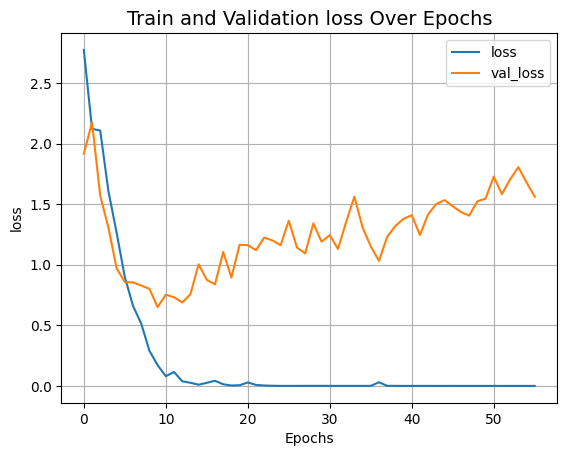

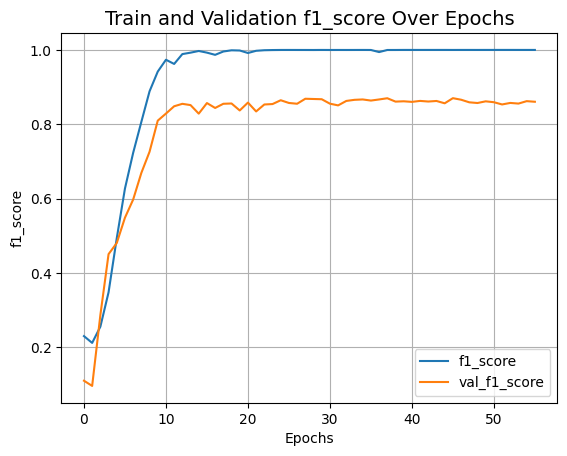

In [ ]:
plot_history("loss")
plot_history('f1_score')

# 2 labels

In [ ]:
train_ds = load_dataset("train")
val_ds = load_dataset("val")
test_ds = load_dataset("test")

train_size = len(train_ds)
val_size = len(val_ds)
test_size = len(test_ds)
print(f'Train Size: {train_size}\nValidation Size: {val_size}\nTest Size: {test_size}')

Train Size: 65399
Validation Size: 26174
Test Size: 17182


In [ ]:
def one_hot_encode_label(label):
  label = tf.cast(label, dtype=tf.int32)
  label = int(label<=3)
  return tf.one_hot(label, depth=2)

train_ds = train_ds.map(lambda x, y: (x, one_hot_encode_label(y)))
val_ds = val_ds.map(lambda x, y: (x, one_hot_encode_label(y)))
test_ds = test_ds.map(lambda x, y: (x, one_hot_encode_label(y)))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().batch(batch_size=2**7).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().batch(batch_size=2**7).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size=2**7).prefetch(buffer_size=AUTOTUNE)

In [ ]:
vit_classifier = create_vit_classifier(num_classes=2)
history, test_result, model = run_experiment(vit_classifier)

Epoch 1/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 201s 194ms/step - accuracy: 0.6865 - f1_score: 0.6871 - loss: 2.9089 - precision_1: 0.6883 - recall_1: 0.4053 - val_accuracy: 0.8630 - val_f1_score: 0.8636 - val_loss: 0.4503 - val_precision_1: 0.9187 - val_recall_1: 0.4700
Epoch 2/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.6799 - f1_score: 0.6845 - loss: 0.5599 - precision_1: 0.7710 - recall_1: 0.3229 - val_accuracy: 0.8776 - val_f1_score: 0.8779 - val_loss: 0.5581 - val_precision_1: 0.8374 - val_recall_1: 0.2942
Epoch 3/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.8109 - f1_score: 0.8109 - loss: 0.5200 - precision_1: 0.6656 - recall_1: 0.6235 - val_accuracy: 0.8684 - val_f1_score: 0.8691 - val_loss: 0.3539 - val_precision_1: 0.5981 - val_recall_1: 0.8951
Epoch 4/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.8605 - f1_score: 0.8631 - loss: 0.3752 - precision_1: 0.7244 - recall_1: 0.7955 - val_accuracy: 0.8964 - val_f1_score: 0.8970 - val_loss: 0.

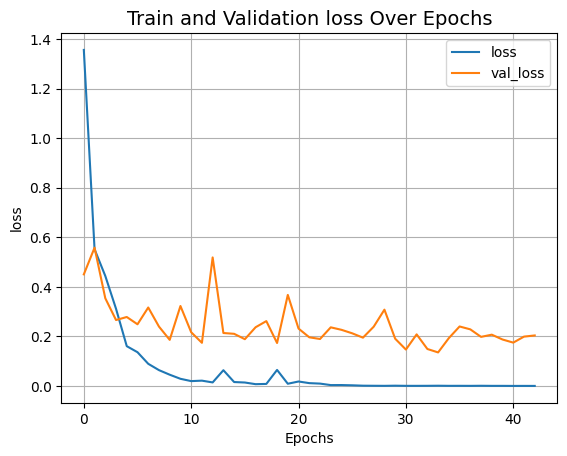

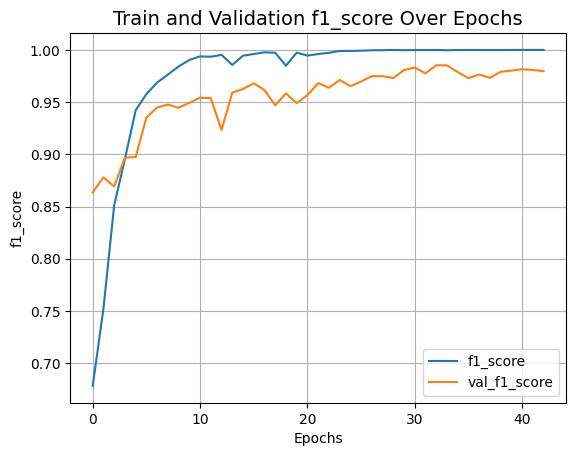

In [ ]:
plot_history("loss")
plot_history('f1_score')